In [2]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 11.7 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import ipywidgets as widgets
from ipywidgets import interact
import neurokit2 as nk

# ==========================================
# 1. FILE CONFIGURATION & LOADING
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join(
    'measurements_oscillometric', 
    'measurements_oscillometric', 
    'o010', 
    'o010.initial.Supine_1.tsv'
)
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return None
        df = pd.read_csv(file_path, sep='\t')
        print(f"Successfully loaded: {os.path.basename(file_path)}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# ==========================================
# 2. SIGNAL PROCESSING (With Auto-Invert)
# ==========================================

def get_sampling_rate(df, time_col='t'):
    if len(df) < 2: return 125.0
    dt = np.mean(np.diff(df[time_col]))
    return 1.0 / dt

def apply_ecg_filters(sig, fs):
    # 1. DC Block
    sos_dc = signal.butter(1, 0.1, btype='highpass', fs=fs, output='sos')
    sig_dc = signal.sosfiltfilt(sos_dc, sig)
    # 2. Lowpass
    sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
    sig_lp = signal.sosfiltfilt(sos_lp, sig_dc)
    # 3. Notch
    sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
    return signal.sosfiltfilt(sos_notch, sig_lp)

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    
    if 'ekg' in df.columns:
        print("1. Filtering...")
        temp_sig = apply_ecg_filters(df['ekg'].values, fs)
        
        # --- FIX: Auto-correct upside down signals ---
        print("2. Checking polarity...")
        corrected_sig, is_inverted = nk.ecg_invert(temp_sig, sampling_rate=fs)
        if is_inverted:
            print("   >> Signal was upside down. Fixed it.")
            
        df_filt['ekg'] = corrected_sig
        
    return df_filt, fs

# ==========================================
# 3. PEAK DETECTION
# ==========================================

def detect_r_peaks(ecg_signal, fs):
    try:
        _, info = nk.ecg_peaks(ecg_signal, sampling_rate=fs)
        return info['ECG_R_Peaks']
    except Exception as e:
        print(f"Error detecting peaks: {e}")
        return []

# ==========================================
# 4. PLOTTING (WITH DYNAMIC ZOOM FIX)
# ==========================================

def plot_interactive_grid(df_raw, df_filt, r_peaks_indices):
    t_min, t_max = df_raw['t'].min(), df_raw['t'].max()
    
    # Pre-calculate peak data
    if len(r_peaks_indices) > 0:
        peak_times = df_filt['t'].iloc[r_peaks_indices].values
        peak_values = df_filt['ekg'].iloc[r_peaks_indices].values
    else:
        peak_times, peak_values = [], []

    def view_waveform(time_range):
        t_start, t_end = time_range
        
        # --- FIX: Slice data for current view ONLY ---
        mask = (df_raw['t'] >= t_start) & (df_raw['t'] <= t_end)
        
        # Get the specific chunk of data we are looking at
        chunk_raw = df_raw.loc[mask, 'ekg']
        chunk_filt = df_filt.loc[mask, 'ekg']
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
        fig.suptitle(f'ECG Analysis ({t_start:.1f}s - {t_end:.1f}s)', fontsize=16)
        
        # --- Plot 1: Raw ---
        axes[0].plot(df_raw['t'], df_raw['ekg'], color='lightblue', lw=1)
        axes[0].set_title('Raw Signal')
        
        # Apply Dynamic Zoom to Raw
        if len(chunk_raw) > 0:
            y_min, y_max = chunk_raw.min(), chunk_raw.max()
            axes[0].set_ylim([y_min, y_max])
        
        # --- Plot 2: Filtered ---
        axes[1].plot(df_filt['t'], df_filt['ekg'], color='blue', lw=1, label='Filtered ECG')
        
        # Overlay peaks
        mask_peaks = (peak_times >= t_start) & (peak_times <= t_end)
        if any(mask_peaks):
            axes[1].scatter(peak_times[mask_peaks], peak_values[mask_peaks], 
                          color='red', s=50, zorder=5, marker='o', label='R-Peaks')
            
        axes[1].set_title(f'Filtered & Corrected')
        axes[1].legend(loc='upper right')
        
        # Apply Dynamic Zoom to Filtered
        if len(chunk_filt) > 0:
            y_min, y_max = chunk_filt.min(), chunk_filt.max()
            # Add a tiny bit of padding (10%) so peaks aren't cut off
            pad = (y_max - y_min) * 0.1
            axes[1].set_ylim([y_min - pad, y_max + pad])
            
        # Format axes
        for ax in axes:
            ax.set_xlim([t_start, t_end])
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Time (s)')
            
        plt.show()

    slider = widgets.FloatRangeSlider(
        value=[t_min, t_min + 5], min=t_min, max=t_max, step=0.5,
        description='Time (s):', continuous_update=False, layout=widgets.Layout(width='95%')
    )
    interact(view_waveform, time_range=slider);

# --- MAIN RUN ---
df = load_abp_data(FULL_FILE_PATH)

if df is not None:
    # 1. Filter & Invert Check
    df_filtered, fs = process_all_signals(df)
    
    # 2. Detect Peaks
    print("\nDetecting R-peaks...")
    r_peaks = detect_r_peaks(df_filtered['ekg'], fs)
    print(f"Found {len(r_peaks)} peaks.")
    
    # 3. Plot
    print("Interactive Plot:")
    plot_interactive_grid(df, df_filtered, r_peaks)

Successfully loaded: o010.initial.Supine_1.tsv
1. Filtering...
2. Checking polarity...
   >> Signal was upside down. Fixed it.

Detecting R-peaks...
Found 41 peaks.
Interactive Plot:


interactive(children=(FloatRangeSlider(value=(0.0, 5.0), continuous_update=False, description='Time (s):', lay…

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import ipywidgets as widgets
from ipywidgets import interact
import neurokit2 as nk

# ==========================================
# 1. FILE CONFIGURATION & LOADING
# ==========================================

KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join(
    'measurements_oscillometric', 
    'measurements_oscillometric', 
    'o200', 
    'o200.initial.Supine_2.tsv'
)
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return None
        df = pd.read_csv(file_path, sep='\t')
        print(f"Successfully loaded: {os.path.basename(file_path)}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# ==========================================
# 2. SIGNAL PROCESSING
# ==========================================

def get_sampling_rate(df, time_col='t'):
    if len(df) < 2: return 125.0
    dt = np.mean(np.diff(df[time_col]))
    return 1.0 / dt

def apply_ppg_filters(sig, fs):
    # 1. Highpass Filter (0.25 Hz)
    sos_hp = signal.butter(N=4, Wn=0.25, btype='highpass', fs=fs, output='sos')
    sig_hp = signal.sosfiltfilt(sos_hp, sig)
    
    # 2. Lowpass Filter (10-12Hz)
    sos_lp = signal.iirdesign(wp=10, ws=12, gpass=1, gstop=60, 
                              analog=False, ftype='ellip', fs=fs, output='sos')
    return signal.sosfiltfilt(sos_lp, sig_hp)

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    if 'optical' in df.columns:
        df_filt['optical'] = apply_ppg_filters(df['optical'].values, fs)
    return df_filt, fs

# ==========================================
# 3. POWER CALCULATION
# ==========================================

def calculate_band_power(sig, fs, f_low, f_high):
    freqs, psd = signal.welch(sig, fs, nperseg=2048)
    idx_min = np.argmax(freqs >= f_low)
    idx_max = np.argmax(freqs > f_high)
    if idx_max == 0: idx_max = len(freqs)
    psd_band = psd[idx_min:idx_max]
    freq_res = freqs[1] - freqs[0]
    band_power = np.sum(psd_band) * freq_res
    power_db = 10 * np.log10(band_power + 1e-12)
    return band_power, power_db

def print_power_comparison(title, raw_sig, filt_sig, fs, f_low, f_high):
    r_pwr, r_db = calculate_band_power(raw_sig, fs, f_low, f_high)
    f_pwr, f_db = calculate_band_power(filt_sig, fs, f_low, f_high)
    if r_pwr > 0:
        pct_remaining = (f_pwr / r_pwr) * 100.0
        pct_removed = 100.0 - pct_remaining
    else:
        pct_remaining, pct_removed = 0.0, 0.0
    print(f"--- {title} ({f_low} Hz - {f_high} Hz) ---")
    print(f"Raw Power:       {r_db:.2f} dB")
    print(f"Filtered Power:  {f_db:.2f} dB")
    print(f"Comparison:      {pct_remaining:.2f}% Retained | {pct_removed:.2f}% Removed\n")

# ==========================================
# 4. PLOTTING
# ==========================================

def plot_interactive_ppg(df_raw, df_filt, ppg_peaks, fs):
    t_min, t_max = df_raw['t'].min(), df_raw['t'].max()
    
    def view_waveform(time_range):
        t_start, t_end = time_range
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
        fig.suptitle(f'PPG Signal Analysis ({t_start:.1f}s - {t_end:.1f}s)', fontsize=16)
        
        # Raw
        axes[0].plot(df_raw['t'], df_raw['optical'], color='lightgreen', lw=1)
        axes[0].set_ylabel('Amplitude (a.u.)'); axes[0].set_title('Raw PPG Signal')
        
        # Filtered
        axes[1].plot(df_filt['t'], df_filt['optical'], color='green', lw=1)
        
        # Peaks
        idx_start = int(t_start * fs)
        idx_end = int(t_end * fs)
        valid_peaks = ppg_peaks[(ppg_peaks >= idx_start) & (ppg_peaks <= idx_end)]
        valid_peaks = valid_peaks[valid_peaks < len(df_filt)]
        
        if len(valid_peaks) > 0:
            peak_times = df_filt['t'].values[valid_peaks]
            peak_values = df_filt['optical'].values[valid_peaks]
            axes[1].scatter(peak_times, peak_values, color='red', s=30, zorder=5, label='Systolic Peaks')
            axes[1].legend(loc='upper right')

        axes[1].set_ylabel('Amplitude (a.u.)'); axes[1].set_title('Filtered PPG Signal')
        
        for ax in axes:
            ax.set_xlim([t_start, t_end]); ax.grid(True, alpha=0.3); ax.set_xlabel('Time (s)')
        plt.show()

    slider = widgets.FloatRangeSlider(
        value=[t_min, t_min + 10], min=t_min, max=t_max, step=0.5,
        description='Time (s):', continuous_update=False, layout=widgets.Layout(width='95%')
    )
    interact(view_waveform, time_range=slider);

# ==========================================
# 5. NEW: TEMPLATE MATCH & DISSIMILARITY
# ==========================================

def assess_ppg_quality_indices(filt_sig, fs):
    """
    Calculates Template Match and Disimilarity indices.
    """
    results = {}
    print("Calculating advanced quality indices (this may take a moment)...")
    
    try:
        # NeuroKit2's ppg_quality function returns a continuous signal of quality
        # We calculate the MEAN of this signal to get a single score for the file.
        
        # 1. Template Match (Orphanidou 2015)
        # 1 = Perfect Match, 0 = No Match
        q_temp = nk.ppg_quality(filt_sig, sampling_rate=fs, method="templatematch")
        results['TemplateMatch_Mean'] = np.mean(q_temp)
        
        # 2. Disimilarity (Sabeti 2019)
        # 0 = Perfect Match (No difference), High = Bad
        q_dissim = nk.ppg_quality(filt_sig, sampling_rate=fs, method="disimilarity")
        results['Disimilarity_Mean'] = np.mean(q_dissim)
        
    except Exception as e:
        print(f"Error computing quality indices: {e}")
        results['TemplateMatch_Mean'] = np.nan
        results['Disimilarity_Mean'] = np.nan
        
    return results

# --- MAIN RUN ---
df = load_abp_data(FULL_FILE_PATH)

if df is not None:
    # 1. Apply Filters
    df_filtered, fs = process_all_signals(df)
    
    # 2. Power Analysis
    print("\n" + "="*50)
    print(f"   PPG POWER PERCENTAGE COMPARISON (fs={fs:.1f}Hz)")
    print("="*50)
    print_power_comparison("BASELINE WANDER", df['optical'].values, df_filtered['optical'].values, fs, 0, 0.25)
    print_power_comparison("MAIN PPG SIGNAL BAND", df['optical'].values, df_filtered['optical'].values, fs, 0.5, 10)
    print_power_comparison("POWER LINE NOISE", df['optical'].values, df_filtered['optical'].values, fs, 50, 60)
    
    # 3. Quality Analysis (Template Match & Disimilarity)
    print("="*50)
    print("   ADVANCED PPG QUALITY INDICES")
    print("="*50)
    
    metrics = assess_ppg_quality_indices(df_filtered['optical'].values, fs)
    
    # --- Template Match ---
    tm_val = metrics['TemplateMatch_Mean']
    print(f"1. Template Match Index (Orphanidou): {tm_val:.4f}")
    if tm_val > 0.8:
        print("   >> EXCELLENT: Heartbeats look very consistent.")
    elif tm_val > 0.5:
        print("   >> ACCEPTABLE: Some variation in beat shape.")
    else:
        print("   >> POOR: Heartbeats vary wildly (likely noise/motion).")
        
    # --- Disimilarity ---
    dis_val = metrics['Disimilarity_Mean']
    print(f"2. Disimilarity Index (Sabeti):     {dis_val:.4f}")
    if dis_val < 1.0: # Thresholds vary, but closer to 0 is better
        print("   >> GOOD: Individual beats differ very little from average.")
    else:
        print("   >> CAUTION: High variability between beats.")

    print("="*50 + "\n")

    # 4. Plot
    try:
        info = nk.ppg_findpeaks(df_filtered['optical'].values, sampling_rate=fs)
        ppg_peaks = info['PPG_Peaks']
    except:
        ppg_peaks = np.array([])

    print("Interactive Plot (PPG Only):")
    plot_interactive_ppg(df, df_filtered, ppg_peaks, fs)

Successfully loaded: o200.initial.Supine_2.tsv

   PPG POWER PERCENTAGE COMPARISON (fs=500.0Hz)
--- BASELINE WANDER (0 Hz - 0.25 Hz) ---
Raw Power:       55.09 dB
Filtered Power:  45.18 dB
Comparison:      10.19% Retained | 89.81% Removed

--- MAIN PPG SIGNAL BAND (0.5 Hz - 10 Hz) ---
Raw Power:       51.61 dB
Filtered Power:  50.71 dB
Comparison:      81.24% Retained | 18.76% Removed

--- POWER LINE NOISE (50 Hz - 60 Hz) ---
Raw Power:       4.27 dB
Filtered Power:  -90.10 dB
Comparison:      0.00% Retained | 100.00% Removed

   ADVANCED PPG QUALITY INDICES
Calculating advanced quality indices (this may take a moment)...
1. Template Match Index (Orphanidou): 0.9295
   >> EXCELLENT: Heartbeats look very consistent.
2. Disimilarity Index (Sabeti):     0.0414
   >> GOOD: Individual beats differ very little from average.

Interactive Plot (PPG Only):


interactive(children=(FloatRangeSlider(value=(0.0, 10.0), continuous_update=False, description='Time (s):', la…

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import ipywidgets as widgets
from ipywidgets import interact
import neurokit2 as nk

# ==========================================
# 1. FILE CONFIGURATION & LOADING
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join(
    'measurements_oscillometric', 
    'measurements_oscillometric', 
    'o100', 
    'o100.initial.Supine_2.tsv'
)
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return None
        df = pd.read_csv(file_path, sep='\t')
        print(f"Successfully loaded: {os.path.basename(file_path)}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# ==========================================
# 2. FILTERING & PROCESSING
# ==========================================

def get_sampling_rate(df, time_col='t'):
    if len(df) < 2: return 125.0
    dt = np.mean(np.diff(df[time_col]))
    return 1.0 / dt

def apply_ecg_filters(sig, fs):
    # 1. DC Block
    sos_dc = signal.butter(1, 0.1, btype='highpass', fs=fs, output='sos')
    sig_dc = signal.sosfiltfilt(sos_dc, sig)
    # 2. Lowpass
    sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
    sig_lp = signal.sosfiltfilt(sos_lp, sig_dc)
    # 3. Notch
    sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
    return signal.sosfiltfilt(sos_notch, sig_lp)

def apply_ppg_filters(sig, fs):
    # 1. Highpass (0.25 Hz)
    sos_hp = signal.butter(N=4, Wn=0.25, btype='highpass', fs=fs, output='sos')
    sig_hp = signal.sosfiltfilt(sos_hp, sig)
    # 2. Lowpass (10-12Hz)
    sos_lp = signal.iirdesign(wp=10, ws=12, gpass=1, gstop=60, 
                              analog=False, ftype='ellip', fs=fs, output='sos')
    return signal.sosfiltfilt(sos_lp, sig_hp)

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    
    # --- PROCESS ECG ---
    if 'ekg' in df.columns:
        print("Processing ECG...")
        temp_ecg = apply_ecg_filters(df['ekg'].values, fs)
        # Check polarity (Auto-Invert)
        corrected_ecg, is_inverted = nk.ecg_invert(temp_ecg, sampling_rate=fs)
        if is_inverted: print("   >> ECG inverted. Flipping upright.")
        df_filt['ekg'] = corrected_ecg
        
    # --- PROCESS PPG ---
    if 'optical' in df.columns:
        print("Processing PPG...")
        df_filt['optical'] = apply_ppg_filters(df['optical'].values, fs)
        
    return df_filt, fs

# ==========================================
# 3. PEAK DETECTION
# ==========================================

def detect_peaks_all(df_filt, fs):
    peaks = {'ecg': [], 'ppg': []}
    
    # ECG Peaks
    if 'ekg' in df_filt.columns:
        try:
            _, info = nk.ecg_peaks(df_filt['ekg'], sampling_rate=fs)
            peaks['ecg'] = info['ECG_R_Peaks']
        except Exception as e: 
            print(f"ECG Peak Error: {e}")
        
    # PPG Peaks
    if 'optical' in df_filt.columns:
        try:
            info = nk.ppg_findpeaks(df_filt['optical'].values, sampling_rate=fs)
            peaks['ppg'] = info['PPG_Peaks']
        except Exception as e:
            print(f"PPG Peak Error: {e}")
        
    return peaks

# ==========================================
# 4. PLOTTING (2x2 GRID + DYNAMIC ZOOM)
# ==========================================

def plot_interactive_full(df_raw, df_filt, peaks_dict):
    t_min, t_max = df_raw['t'].min(), df_raw['t'].max()
    
    # Pre-calculate peak data
    ecg_indices = peaks_dict.get('ecg', [])
    ppg_indices = peaks_dict.get('ppg', [])
    
    ecg_peak_t = df_filt['t'].iloc[ecg_indices].values if len(ecg_indices) > 0 else []
    ecg_peak_y = df_filt['ekg'].iloc[ecg_indices].values if len(ecg_indices) > 0 else []
    
    ppg_peak_t = df_filt['t'].iloc[ppg_indices].values if len(ppg_indices) > 0 else []
    ppg_peak_y = df_filt['optical'].iloc[ppg_indices].values if len(ppg_indices) > 0 else []

    def view_waveform(time_range):
        t_start, t_end = time_range
        mask = (df_raw['t'] >= t_start) & (df_raw['t'] <= t_end)
        
        # 2 Rows (ECG, PPG), 2 Cols (Raw, Filtered)
        fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
        fig.suptitle(f'Signal Analysis ({t_start:.1f}s - {t_end:.1f}s)', fontsize=16)
        
        # --- ROW 1: ECG ---
        # Raw ECG
        axes[0,0].plot(df_raw['t'], df_raw['ekg'], color='lightblue', lw=1)
        axes[0,0].set_title('Raw ECG'); axes[0,0].set_ylabel('Amplitude')
        chunk_raw_ecg = df_raw.loc[mask, 'ekg']
        if len(chunk_raw_ecg) > 0:
            axes[0,0].set_ylim(chunk_raw_ecg.min(), chunk_raw_ecg.max())

        # Filtered ECG
        axes[0,1].plot(df_filt['t'], df_filt['ekg'], color='blue', lw=1, label='Filt ECG')
        mask_peaks_ecg = (ecg_peak_t >= t_start) & (ecg_peak_t <= t_end)
        if any(mask_peaks_ecg):
            axes[0,1].scatter(ecg_peak_t[mask_peaks_ecg], ecg_peak_y[mask_peaks_ecg], color='red', s=40, zorder=5)
        axes[0,1].set_title('Filtered ECG + R-Peaks')
        chunk_filt_ecg = df_filt.loc[mask, 'ekg']
        if len(chunk_filt_ecg) > 0:
            pad = (chunk_filt_ecg.max() - chunk_filt_ecg.min()) * 0.1
            axes[0,1].set_ylim(chunk_filt_ecg.min() - pad, chunk_filt_ecg.max() + pad)

        # --- ROW 2: PPG ---
        # Raw PPG
        axes[1,0].plot(df_raw['t'], df_raw['optical'], color='lightgreen', lw=1)
        axes[1,0].set_title('Raw PPG'); axes[1,0].set_ylabel('Amplitude (a.u.)')
        chunk_raw_ppg = df_raw.loc[mask, 'optical']
        if len(chunk_raw_ppg) > 0:
             axes[1,0].set_ylim(chunk_raw_ppg.min(), chunk_raw_ppg.max())

        # Filtered PPG
        axes[1,1].plot(df_filt['t'], df_filt['optical'], color='green', lw=1, label='Filt PPG')
        mask_peaks_ppg = (ppg_peak_t >= t_start) & (ppg_peak_t <= t_end)
        if any(mask_peaks_ppg):
            axes[1,1].scatter(ppg_peak_t[mask_peaks_ppg], ppg_peak_y[mask_peaks_ppg], color='orange', s=40, zorder=5)
        axes[1,1].set_title('Filtered PPG + Sys-Peaks')
        chunk_filt_ppg = df_filt.loc[mask, 'optical']
        if len(chunk_filt_ppg) > 0:
            pad = (chunk_filt_ppg.max() - chunk_filt_ppg.min()) * 0.1
            axes[1,1].set_ylim(chunk_filt_ppg.min() - pad, chunk_filt_ppg.max() + pad)
        
        # Common Settings
        for ax in axes.flatten():
            ax.set_xlim([t_start, t_end])
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Time (s)')
            
        plt.show()

    slider = widgets.FloatRangeSlider(
        value=[t_min, t_min + 5], min=t_min, max=t_max, step=0.5,
        description='Time (s):', continuous_update=False, layout=widgets.Layout(width='95%')
    )
    interact(view_waveform, time_range=slider);

# --- MAIN RUN ---
df = load_abp_data(FULL_FILE_PATH)

if df is not None:
    # 1. Process Signals (Filter + Invert Check)
    df_filtered, fs = process_all_signals(df)
    
    # 2. Detect Peaks
    print("\nDetecting Peaks for both signals...")
    peaks = detect_peaks_all(df_filtered, fs)
    print(f"Peaks Found -> ECG: {len(peaks['ecg'])} | PPG: {len(peaks['ppg'])}")
    
    # 3. Plot
    print("Interactive Plot:")
    plot_interactive_full(df, df_filtered, peaks)

Successfully loaded: o100.initial.Supine_2.tsv
Processing ECG...
   >> ECG inverted. Flipping upright.
Processing PPG...

Detecting Peaks for both signals...
Peaks Found -> ECG: 43 | PPG: 43
Interactive Plot:


interactive(children=(FloatRangeSlider(value=(0.0, 5.0), continuous_update=False, description='Time (s):', lay…

Processing signals (Filtering & Auto-Invert)...

Scanning Signal (Duration: 8s, Step: 1s)
Metrics: ECG(Zhao2018) + PPG(Orphanidou & Sabeti)
--------------------------------------------------------------------------------
TIME WINDOW          | SCORE | DETAILS
--------------------------------------------------------------------------------
0.0s - 8.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
1.0s - 9.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
2.0s - 10.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
3.0s - 11.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
4.0s - 12.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
5.0s - 13.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
6.0s - 14.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
7.0s - 15.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
8.0s - 16.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
9.0s - 17.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
10.0s - 18.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
11.0s - 19.0s     |  7/10  | ECG:Ok, PPG:Exc(T1.00)
12.0s - 20.0s     |  7/10  | ECG:Ok, PPG:Exc(T1

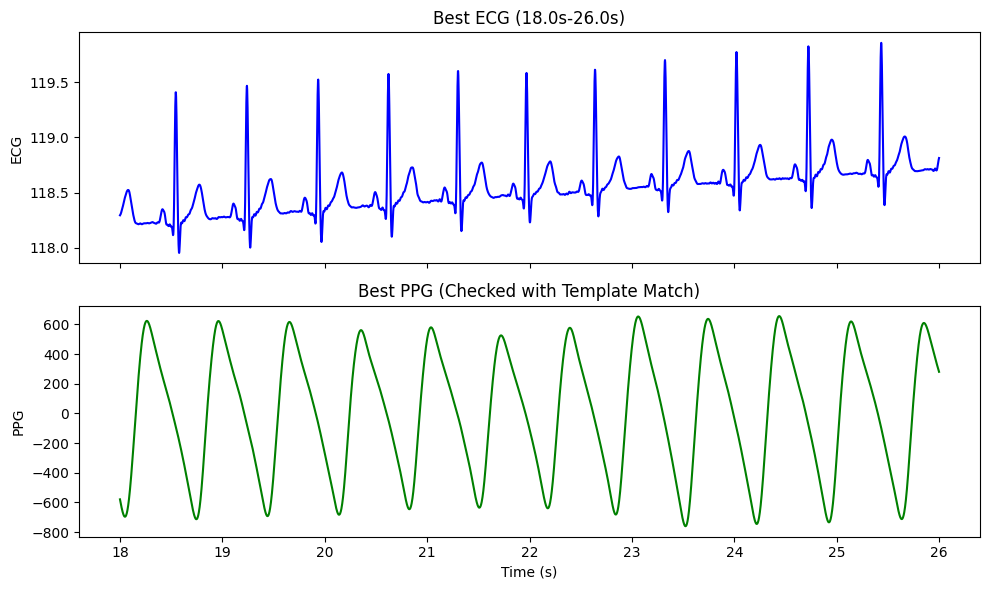

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

# ==========================================
# 1. FILE CONFIGURATION & LOADING
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join(
    'measurements_oscillometric', 
    'measurements_oscillometric', 
    'o100', 
    'o100.initial.Supine_2.tsv'
)
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return None
        df = pd.read_csv(file_path, sep='\t')
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# ==========================================
# 2. PROCESSING (Filter & Auto-Invert)
# ==========================================

def get_sampling_rate(df, time_col='t'):
    if len(df) < 2: return 125.0
    dt = np.mean(np.diff(df[time_col]))
    return 1.0 / dt

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    
    # ECG Filter + Auto-Flip
    if 'ekg' in df.columns:
        # Filter
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, signal.sosfiltfilt(sos_notch, df['ekg'].values))
        # Invert check
        corrected_ecg, is_inverted = nk.ecg_invert(sig_lp, sampling_rate=fs)
        df_filt['ekg'] = corrected_ecg
        
    # PPG Filter (Bandpass 0.5-10Hz approx)
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. ADVANCED QUALITY SCORING
# ==========================================

def get_segment_quality(ecg_chunk, ppg_chunk, fs):
    """
    Calculates Quality Score (0-10).
    ECG: Zhao 2018 (0-5 pts)
    PPG: Orphanidou + Sabeti (0-5 pts)
    """
    score = 0
    details = []
    
    # --- 1. ECG SCORE (0-5 pts) ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': 
            score += 5
            details.append("ECG:Exc")
        elif q_class == 'Barely acceptable': 
            score += 2
            details.append("ECG:Ok")
        else: 
            details.append("ECG:Bad")
    except:
        details.append("ECG:Err")

    # --- 2. PPG SCORE (0-5 pts) ---
    # Using the advanced methods you requested
    try:
        # A. Template Match (Orphanidou 2015) -> 1.0 is Perfect
        q_temp = nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch")
        val_temp = np.mean(q_temp)
        
        # B. Disimilarity (Sabeti 2019) -> 0.0 is Perfect
        q_dissim = nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="disimilarity")
        val_dissim = np.mean(q_dissim)
        
        # Scoring Logic based on thresholds
        if val_temp > 0.85 and val_dissim < 1.5:
            score += 5
            details.append(f"PPG:Exc(T{val_temp:.2f})")
        elif val_temp > 0.6:
            score += 3
            details.append(f"PPG:Ok(T{val_temp:.2f})")
        elif val_temp > 0.4:
            score += 1
            details.append(f"PPG:Weak(T{val_temp:.2f})")
        else:
            details.append(f"PPG:Bad(T{val_temp:.2f})")
            
    except Exception as e:
        details.append("PPG:CalcErr")

    return score, ", ".join(details)

def scan_and_print_quality(df, fs, duration_sec=8, step_sec=1):
    window_samples = int(duration_sec * fs)
    step_samples = int(step_sec * fs)
    total_samples = len(df)
    
    best_score = -1
    best_start_idx = 0
    
    print(f"\nScanning Signal (Duration: {duration_sec}s, Step: {step_sec}s)")
    print("Metrics: ECG(Zhao2018) + PPG(Orphanidou & Sabeti)")
    print("-" * 80)
    print(f"{'TIME WINDOW':<20} | {'SCORE':<5} | {'DETAILS'}")
    print("-" * 80)
    
    for i in range(0, total_samples - window_samples, step_samples):
        # Extract Data
        ecg_chunk = df['ekg'].iloc[i : i + window_samples].values
        ppg_chunk = df['optical'].iloc[i : i + window_samples].values
        
        # Calculate Advanced Score
        current_score, reason = get_segment_quality(ecg_chunk, ppg_chunk, fs)
        
        # Print
        t_start = df['t'].iloc[i]
        t_end = df['t'].iloc[i + window_samples]
        print(f"{t_start:.1f}s - {t_end:.1f}s     | {current_score:>2}/10  | {reason}")
        
        # Track Best
        if current_score > best_score:
            best_score = current_score
            best_start_idx = i
            
    print("-" * 80)
    
    # Extract Best
    best_df = df.iloc[best_start_idx : best_start_idx + window_samples].copy()
    t0 = df['t'].iloc[best_start_idx]
    t1 = df['t'].iloc[best_start_idx + window_samples]
    
    return best_df, t0, t1, best_score

# ==========================================
# MAIN EXECUTION
# ==========================================
df = load_abp_data(FULL_FILE_PATH)

if df is not None:
    print("Processing signals (Filtering & Auto-Invert)...")
    df_filtered, fs = process_all_signals(df)
    
    # Scan with advanced PPG metrics
    df_best, t0, t1, score = scan_and_print_quality(df_filtered, fs, duration_sec=8, step_sec=1)
    
    print(f"\nWINNER SELECTION: {t0:.1f}s - {t1:.1f}s (Score: {score}/10)")
    
    # Plot Result
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    axes[0].plot(df_best['t'], df_best['ekg'], color='blue')
    axes[0].set_title(f"Best ECG ({t0:.1f}s-{t1:.1f}s)")
    axes[0].set_ylabel('ECG')
    
    axes[1].plot(df_best['t'], df_best['optical'], color='green')
    axes[1].set_title(f"Best PPG (Checked with Template Match)")
    axes[1].set_ylabel('PPG')
    axes[1].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()

Processing signals...

Scanning for Good Segments (Score >= 8)...
Metrics: ECG(Zhao2018) + PPG(Orphanidou & Sabeti)
--------------------------------------------------------------------------------
Plotting Match #1: 0.0s - 8.0s (Score: 10/10) | ECG:Exc, PPG:Exc(0.87)


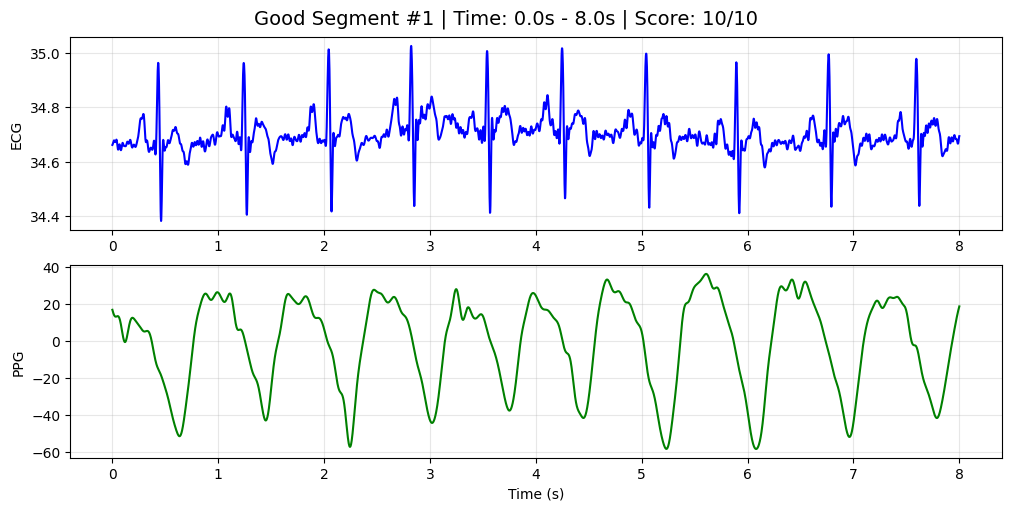

Plotting Match #2: 1.0s - 9.0s (Score: 8/10) | ECG:Exc, PPG:Ok(0.77)


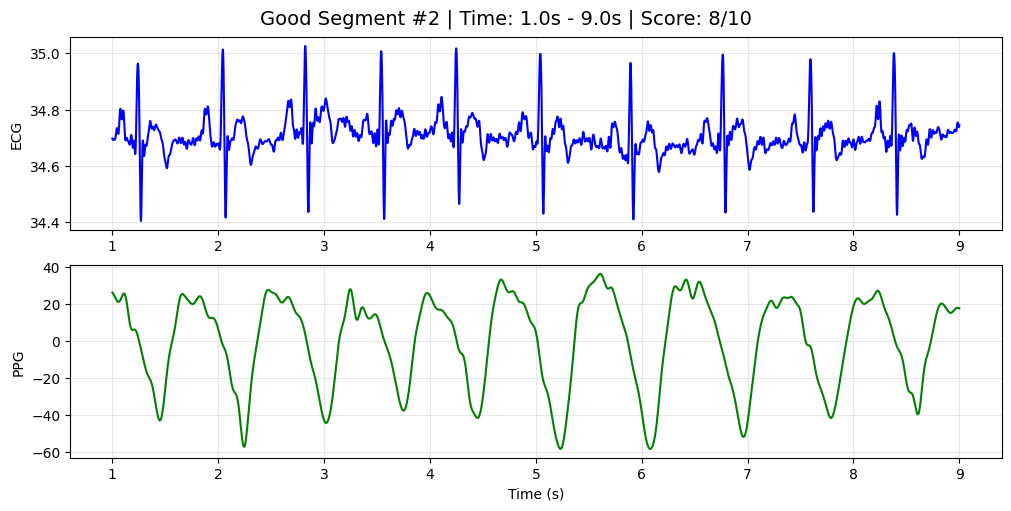

Plotting Match #3: 2.0s - 10.0s (Score: 8/10) | ECG:Exc, PPG:Ok(0.74)


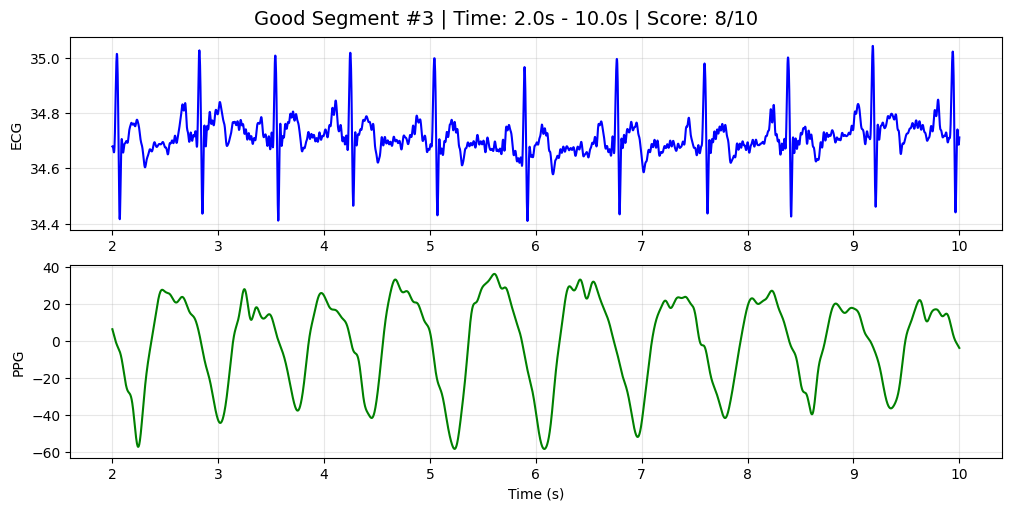

Plotting Match #4: 3.0s - 11.0s (Score: 8/10) | ECG:Exc, PPG:Ok(0.81)


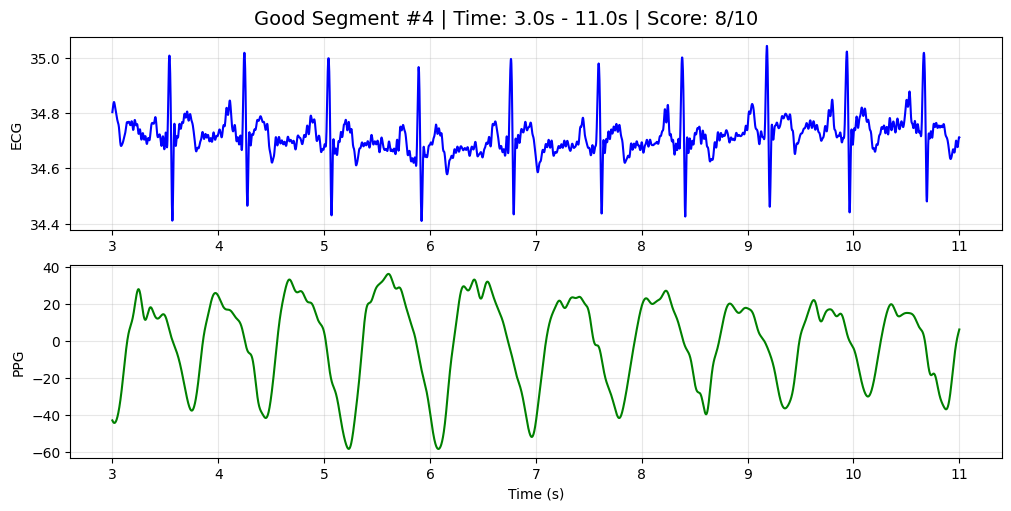

Plotting Match #5: 4.0s - 12.0s (Score: 8/10) | ECG:Exc, PPG:Ok(0.79)


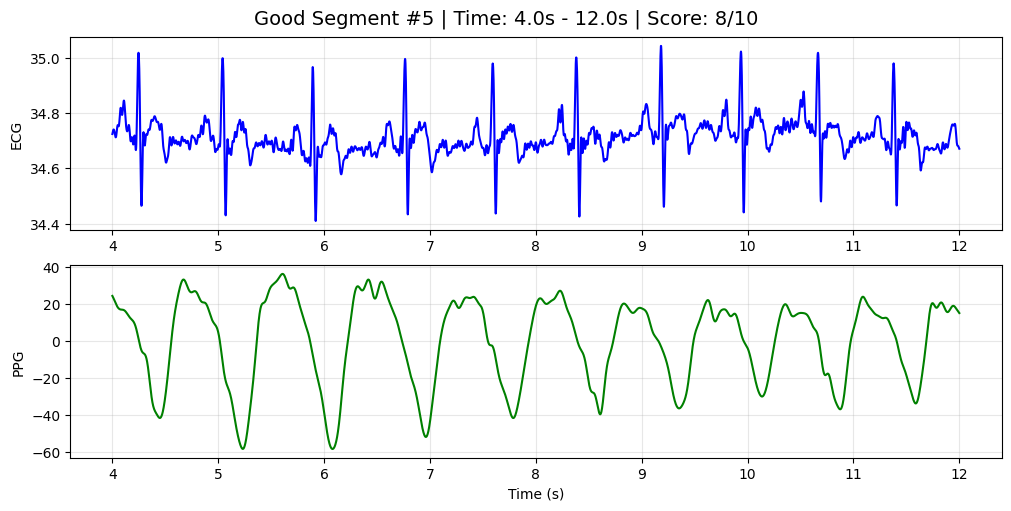

Plotting Match #6: 6.0s - 14.0s (Score: 8/10) | ECG:Exc, PPG:Ok(0.82)


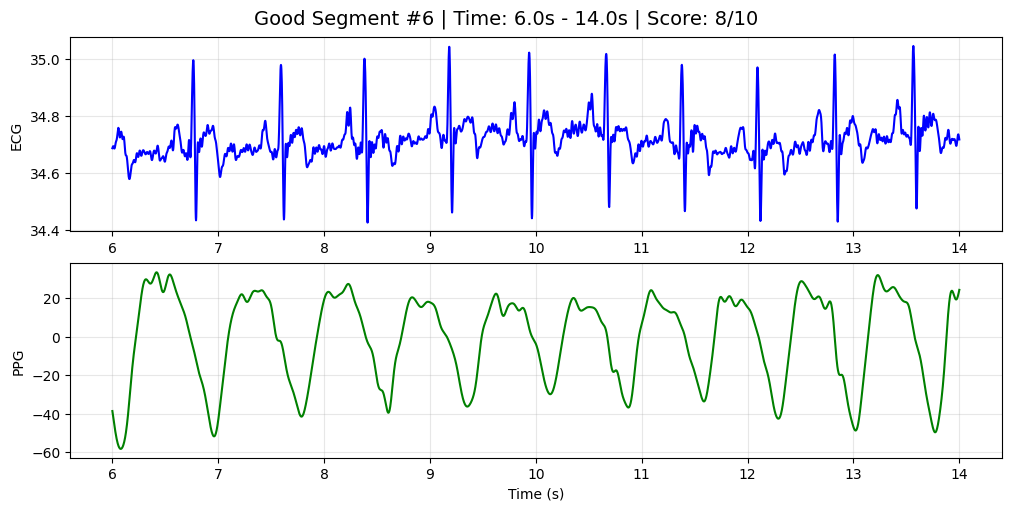

Plotting Match #7: 7.0s - 15.0s (Score: 8/10) | ECG:Exc, PPG:Ok(0.78)


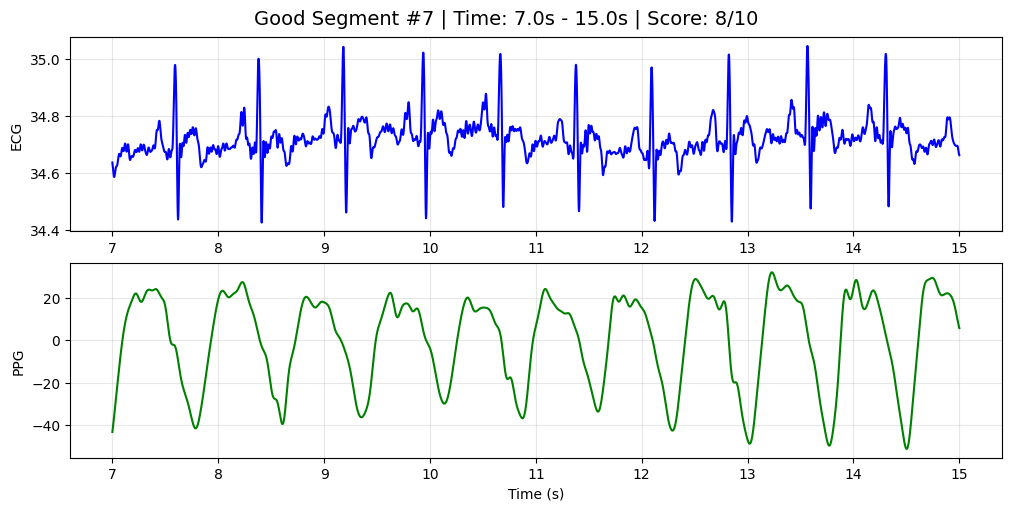

Plotting Match #8: 8.0s - 16.0s (Score: 10/10) | ECG:Exc, PPG:Exc(0.98)


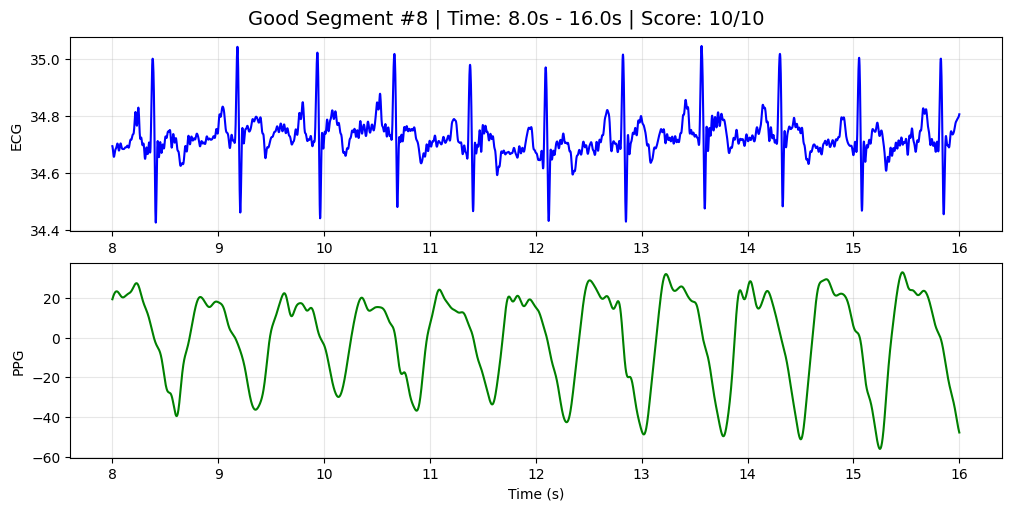

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

# ==========================================
# 1. FILE CONFIGURATION & LOADING
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join(
    'measurements_oscillometric', 
    'measurements_oscillometric', 
    'o150', 
    'o150.initial.Supine_2.tsv'
)
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return None
        df = pd.read_csv(file_path, sep='\t')
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# ==========================================
# 2. PROCESSING (Filters + Invert Fix)
# ==========================================

def get_sampling_rate(df, time_col='t'):
    if len(df) < 2: return 125.0
    dt = np.mean(np.diff(df[time_col]))
    return 1.0 / dt

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    
    # ECG Processing
    if 'ekg' in df.columns:
        # Filter
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, signal.sosfiltfilt(sos_notch, df['ekg'].values))
        # Invert Check
        corrected_ecg, is_inverted = nk.ecg_invert(sig_lp, sampling_rate=fs)
        df_filt['ekg'] = corrected_ecg
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. QUALITY SCORING
# ==========================================

def get_segment_quality(ecg_chunk, ppg_chunk, fs):
    score = 0
    details = []
    
    # --- ECG CHECK (Zhao 2018) ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': 
            score += 5
            details.append("ECG:Exc")
        elif q_class == 'Barely acceptable': 
            score += 2
            details.append("ECG:Ok")
        else: 
            details.append("ECG:Bad")
    except:
        details.append("ECG:Err")

    # --- PPG CHECK (Template + Dissimilarity) ---
    try:
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        q_dissim = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="disimilarity"))
        
        if q_temp > 0.85 and q_dissim < 1.5:
            score += 5
            details.append(f"PPG:Exc({q_temp:.2f})")
        elif q_temp > 0.6:
            score += 3
            details.append(f"PPG:Ok({q_temp:.2f})")
        else:
            details.append(f"PPG:Bad({q_temp:.2f})")
            
    except:
        details.append("PPG:Err")

    return score, ", ".join(details)

# ==========================================
# 4. SCAN & PLOT FUNCTION
# ==========================================

def scan_and_plot_good_segments(df, fs, duration_sec=8, step_sec=1, min_score_to_plot=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(step_sec * fs)
    total_samples = len(df)
    
    print(f"\nScanning for Good Segments (Score >= {min_score_to_plot})...")
    print(f"Metrics: ECG(Zhao2018) + PPG(Orphanidou & Sabeti)")
    print("-" * 80)
    
    count = 0
    
    for i in range(0, total_samples - window_samples, step_samples):
        # Extract Chunk
        ecg_chunk = df['ekg'].iloc[i : i + window_samples].values
        ppg_chunk = df['optical'].iloc[i : i + window_samples].values
        t_start = df['t'].iloc[i]
        t_end = df['t'].iloc[i + window_samples]
        
        # Calculate Score
        score, reason = get_segment_quality(ecg_chunk, ppg_chunk, fs)
        
        # If Good, Plot It!
        if score >= min_score_to_plot:
            count += 1
            print(f"Plotting Match #{count}: {t_start:.1f}s - {t_end:.1f}s (Score: {score}/10) | {reason}")
            
            # Create Plot
            fig, axes = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)
            fig.suptitle(f"Good Segment #{count} | Time: {t_start:.1f}s - {t_end:.1f}s | Score: {score}/10", fontsize=14)
            
            # Plot ECG
            axes[0].plot(np.linspace(t_start, t_end, len(ecg_chunk)), ecg_chunk, color='blue')
            axes[0].set_ylabel("ECG")
            axes[0].grid(True, alpha=0.3)
            
            # Plot PPG
            axes[1].plot(np.linspace(t_start, t_end, len(ppg_chunk)), ppg_chunk, color='green')
            axes[1].set_ylabel("PPG")
            axes[1].set_xlabel("Time (s)")
            axes[1].grid(True, alpha=0.3)
            
            plt.show()
            
            # Optional: Stop after finding 5 good ones to prevent spamming plots
            # if count >= 5: 
            #     print("Limit reached (5 plots). Stopping scan.")
            #     break

    if count == 0:
        print("No segments found that met the quality threshold.")

# ==========================================
# MAIN EXECUTION
# ==========================================
df = load_abp_data(FULL_FILE_PATH)

if df is not None:
    print("Processing signals...")
    df_filtered, fs = process_all_signals(df)
    
    # Run the scanner
    # You can adjust 'min_score_to_plot' (e.g., set to 10 for perfect only, or 5 for decent)
    scan_and_plot_good_segments(df_filtered, fs, min_score_to_plot=8)

Processing signals...

Scanning (Score >= 8)...
Metrics: ECG(Zhao) + PPG(Template) + ECG_VARIANCE Check
------------------------------------------------------------------------------------------
Match #1: 0.0s - 8.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


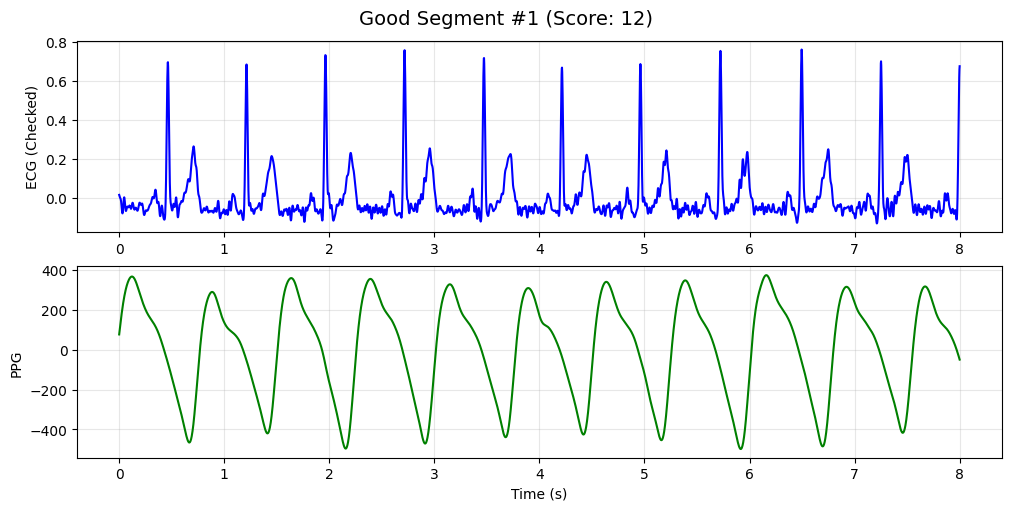

Match #2: 1.0s - 9.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


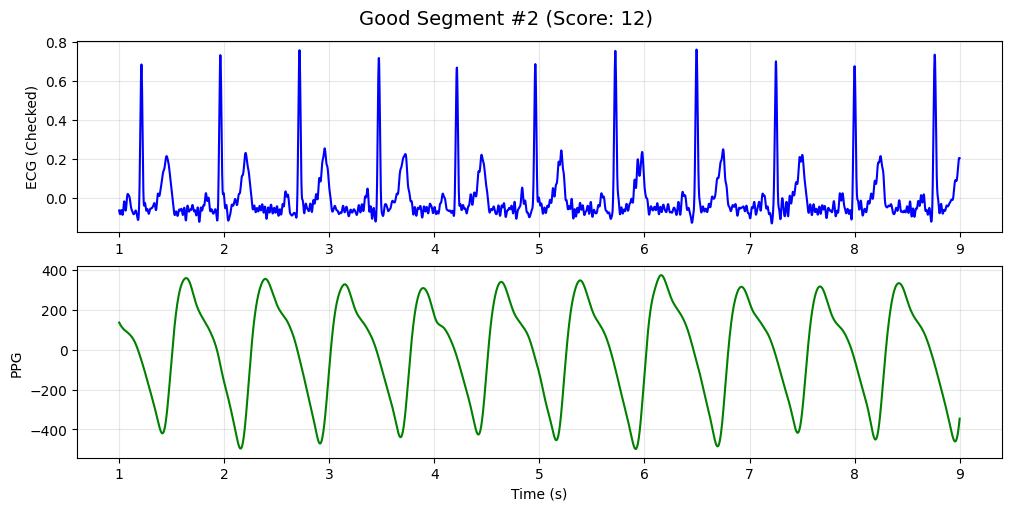

Match #3: 2.0s - 10.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


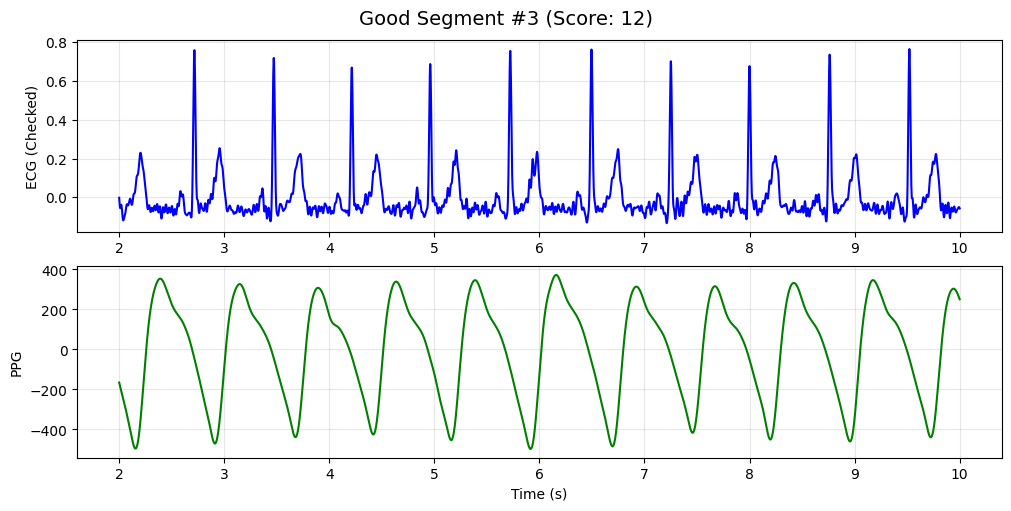

Match #4: 3.0s - 11.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


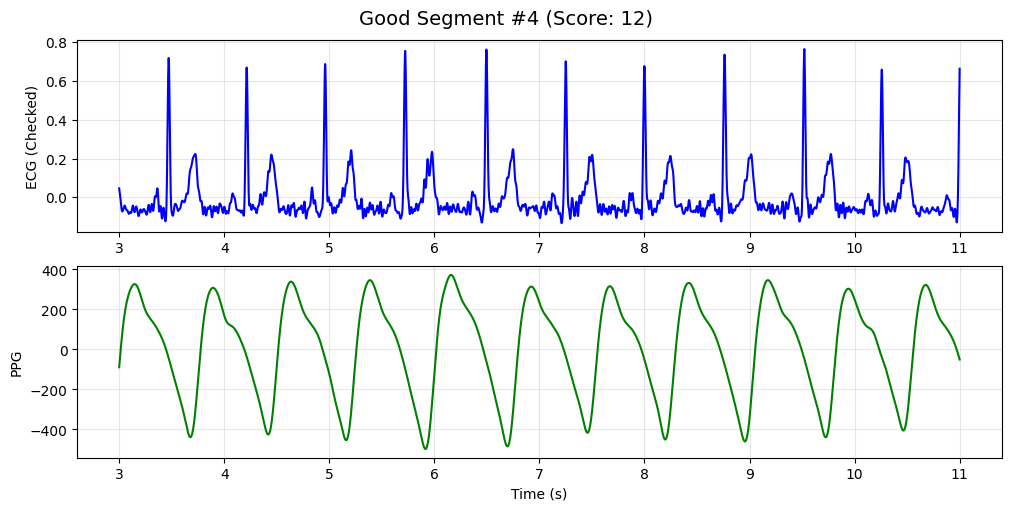

Match #5: 4.0s - 12.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


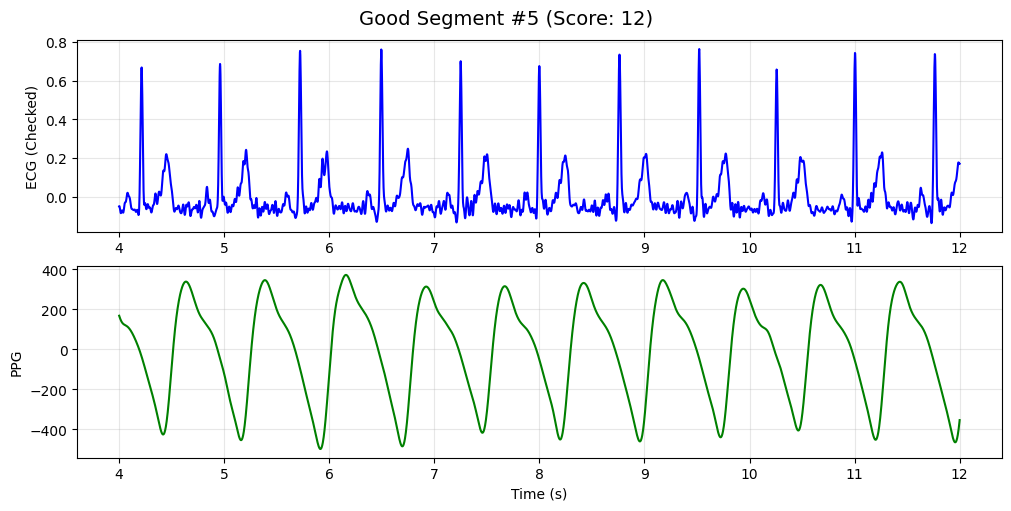

Match #6: 5.0s - 13.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


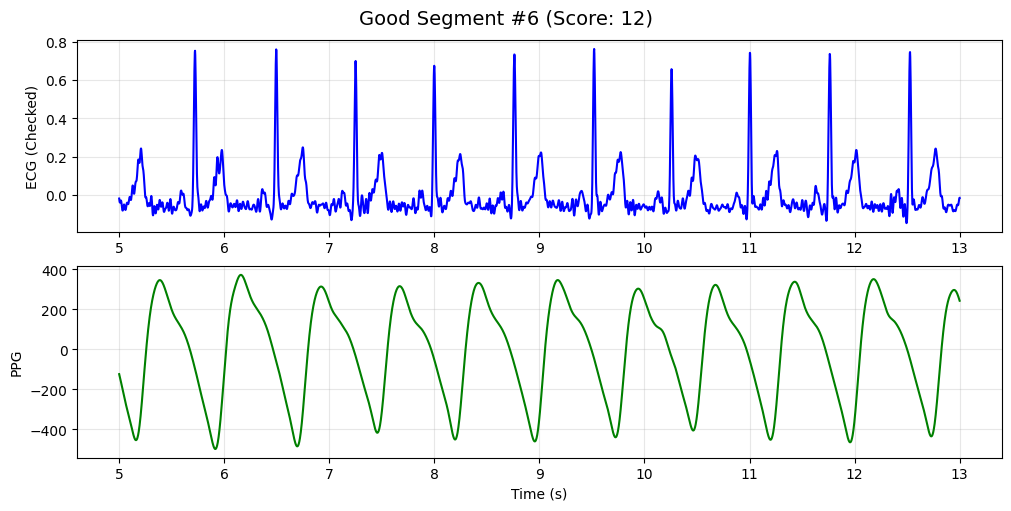

Match #7: 6.0s - 14.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


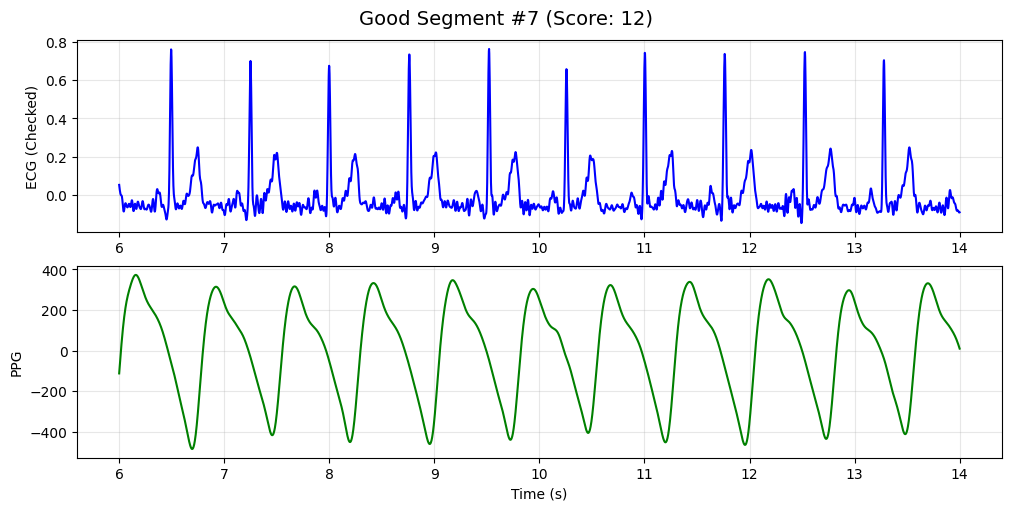

Match #8: 7.0s - 15.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


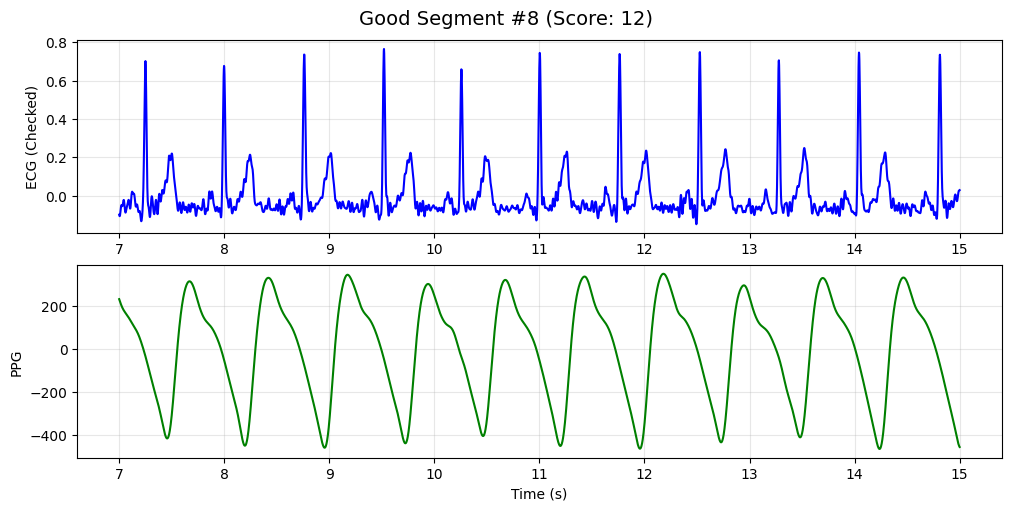

Match #9: 8.0s - 16.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


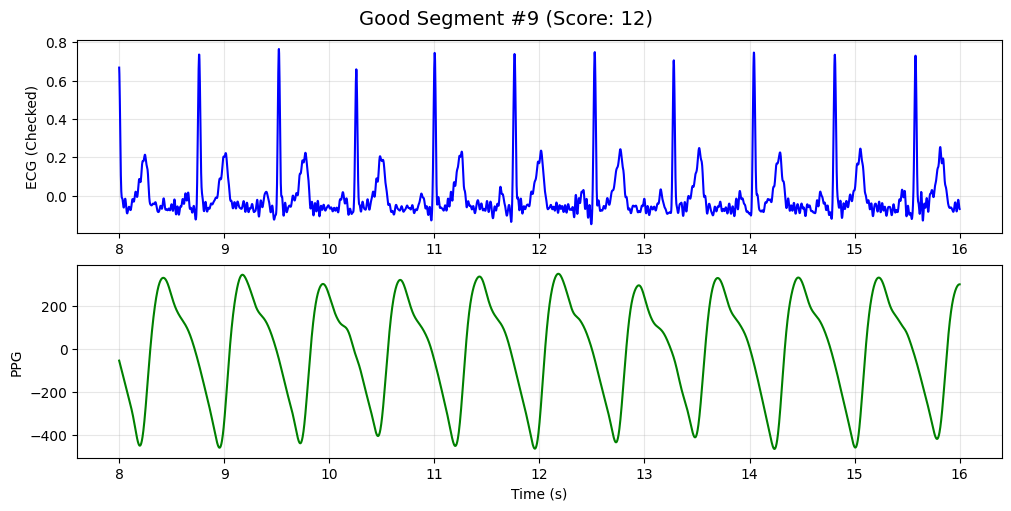

Match #10: 9.0s - 17.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


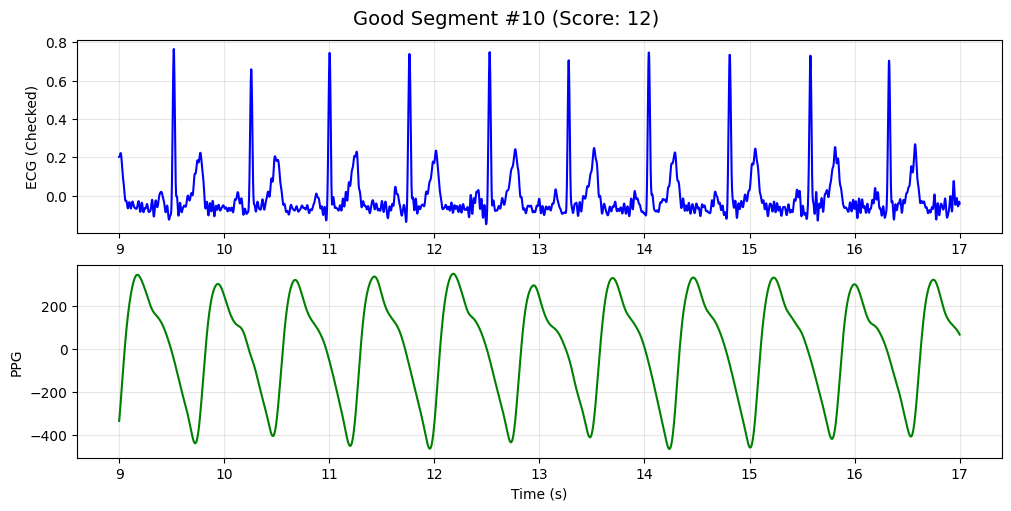

Match #11: 10.0s - 18.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


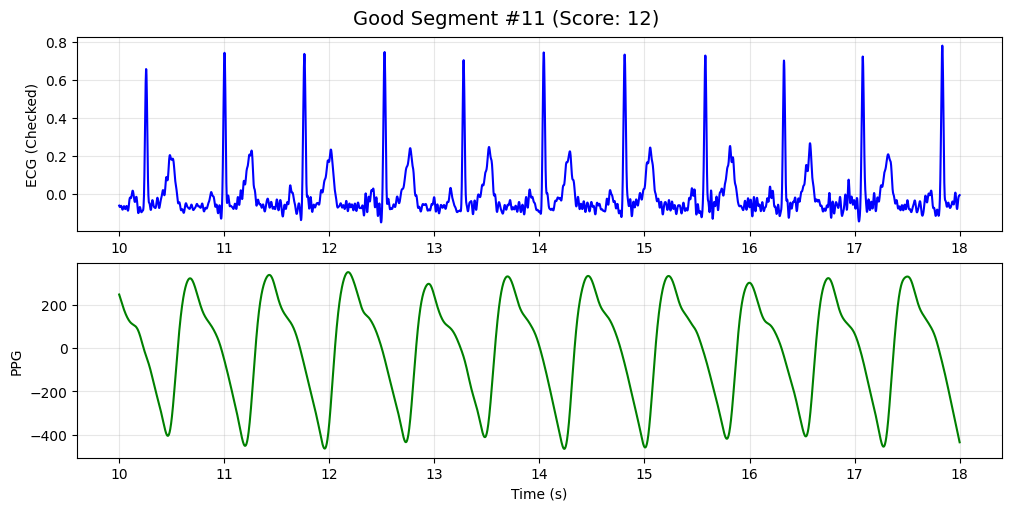

Match #12: 11.0s - 19.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


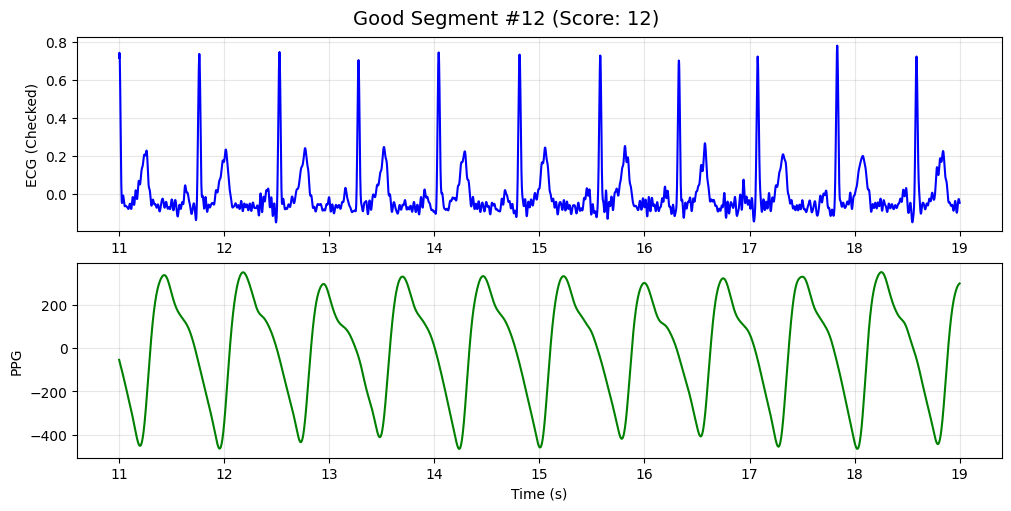

Match #13: 12.0s - 20.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


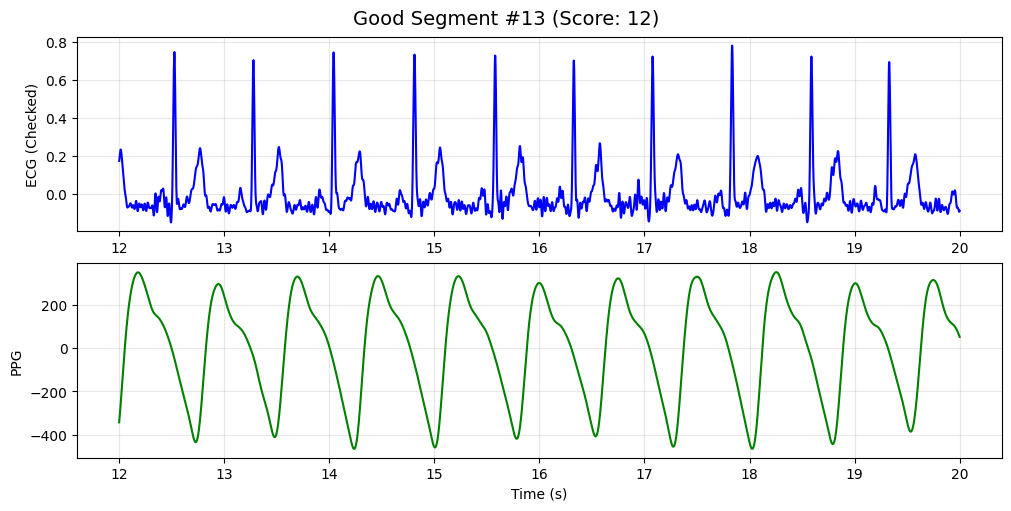

Match #14: 13.0s - 21.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


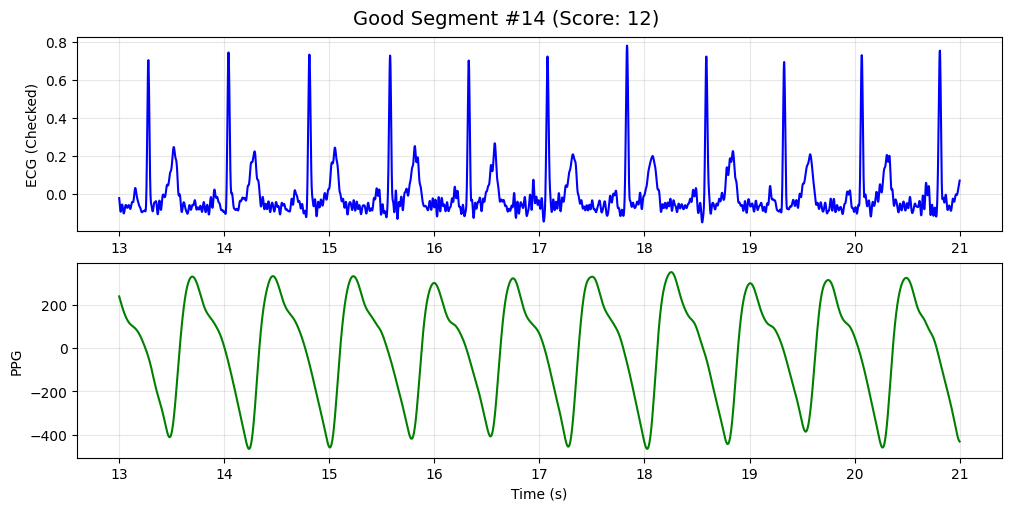

Match #15: 14.0s - 22.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


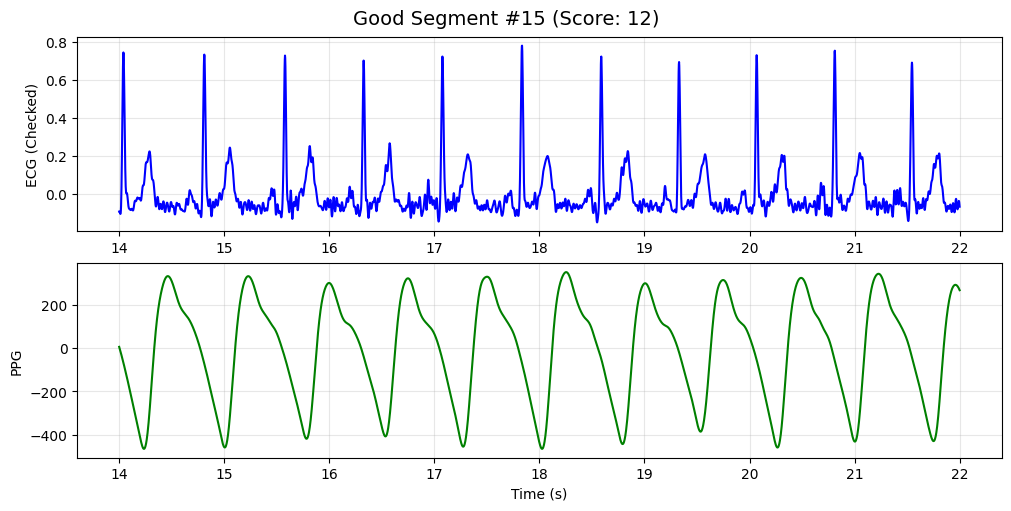

Match #16: 15.0s - 23.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


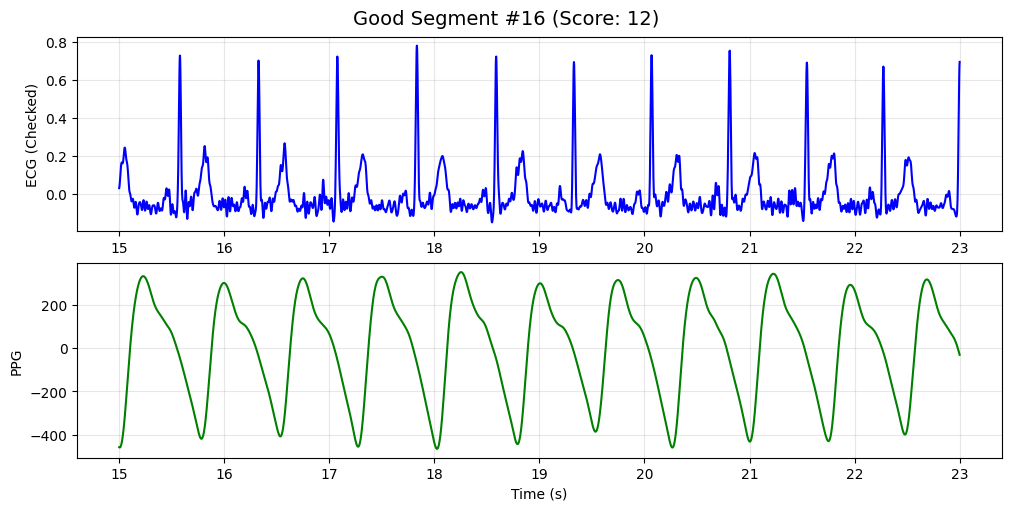

Match #17: 16.0s - 24.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


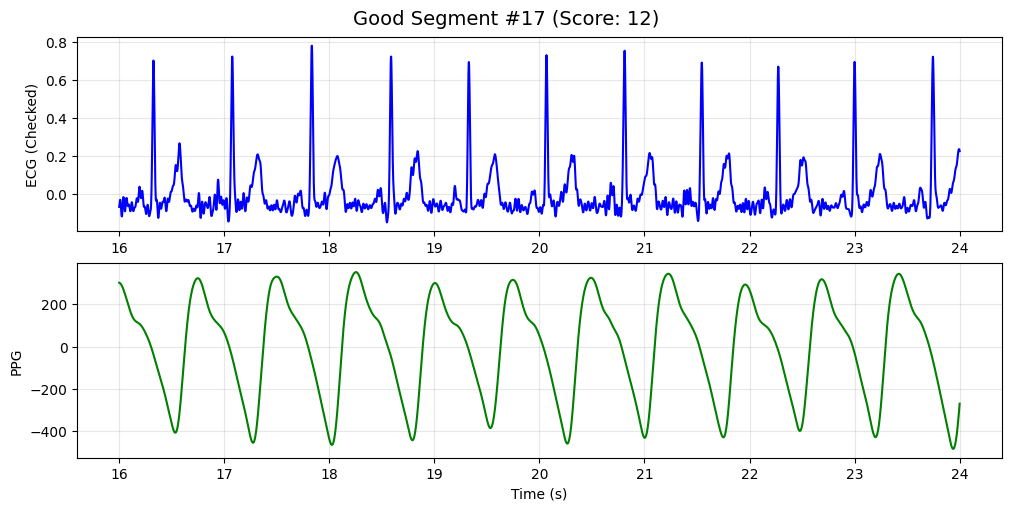

Match #18: 17.0s - 25.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


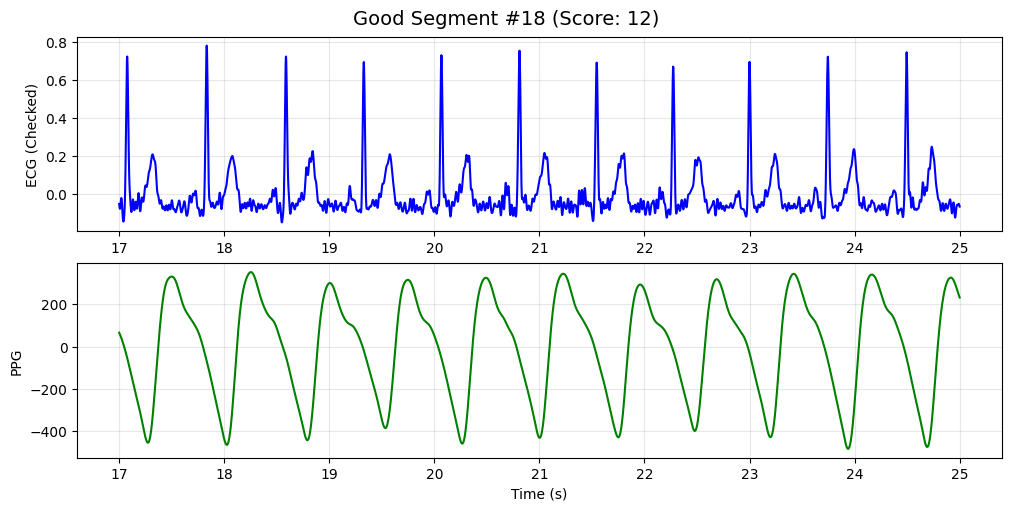

Match #19: 18.0s - 26.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


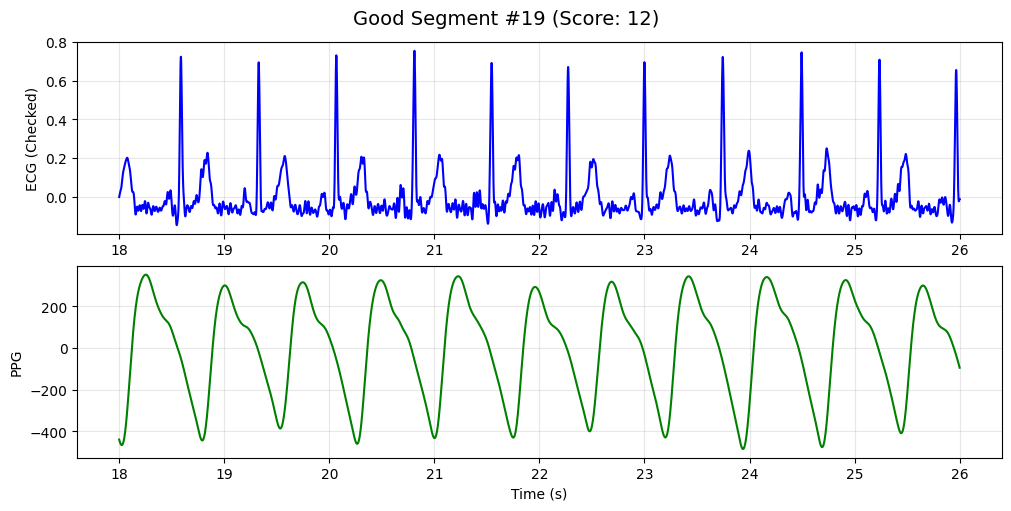

Match #20: 19.0s - 27.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


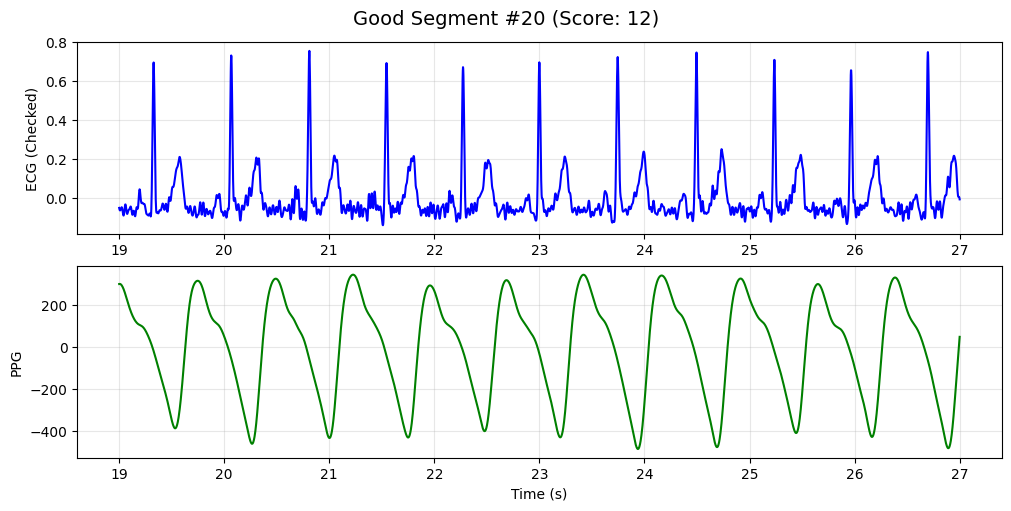

Match #21: 20.0s - 28.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


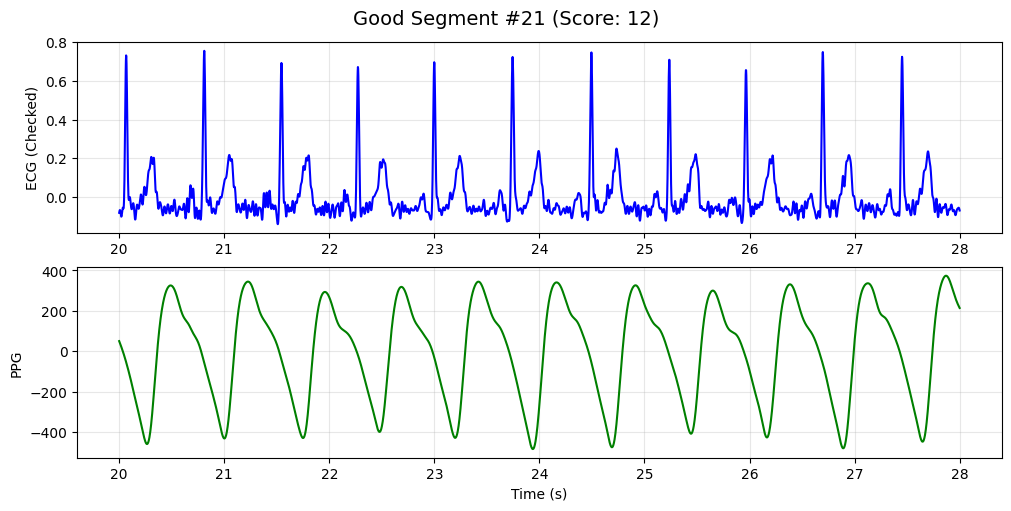

Match #22: 21.0s - 29.0s (Score: 12) | ECG:Exc, PPG:Exc, ECG_VAR:Ok(0.1)


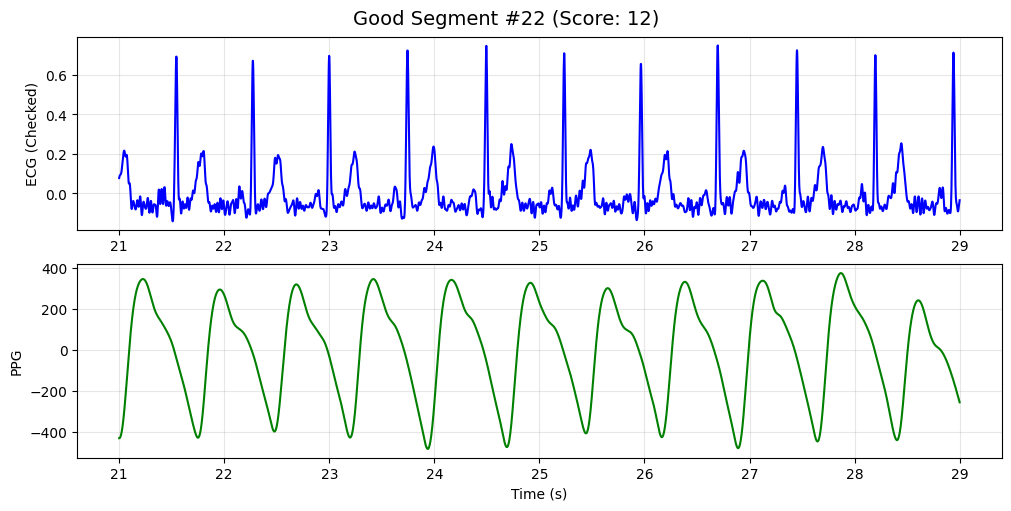

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

# ==========================================
# 1. FILE CONFIGURATION & LOADING
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join(
    'measurements_oscillometric', 
    'measurements_oscillometric', 
    'o099', 
    'o099.initial.Supine_1.tsv'
)
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return None
        df = pd.read_csv(file_path, sep='\t')
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# ==========================================
# 2. SIGNAL PROCESSING
# ==========================================

def get_sampling_rate(df, time_col='t'):
    if len(df) < 2: return 125.0
    dt = np.mean(np.diff(df[time_col]))
    return 1.0 / dt

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    
    # ECG Processing
    if 'ekg' in df.columns:
        # 1. Highpass Filter (0.5 Hz) -> REMOVES BASELINE WANDER
        # This is the missing piece that flattens the line!
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        
        # 2. Notch Filter (50-70 Hz) -> Removes Power Line Hum
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        
        # 3. Lowpass Filter (40 Hz) -> Removes Muscle Noise
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, sig_notch)
        
        # 4. Invert Check
        corrected_ecg, _ = nk.ecg_invert(sig_lp, sampling_rate=fs)
        df_filt['ekg'] = corrected_ecg
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. QUALITY SCORING (Checking ECG Variance)
# ==========================================

def get_segment_quality(ecg_chunk, ppg_chunk, fs):
    score = 0
    details = []
    
    # --- A. ECG CHECK (Zhao 2018) ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': 
            score += 5
            details.append("ECG:Exc")
        elif q_class == 'Barely acceptable': 
            score += 2
            details.append("ECG:Ok")
        else: 
            details.append("ECG:Bad")
    except:
        details.append("ECG:Err")

    # --- B. PPG CHECK (Template + Dissimilarity) ---
    try:
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        q_dissim = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="disimilarity"))
        
        if q_temp > 0.85 and q_dissim < 1.5:
            score += 5
            details.append(f"PPG:Exc")
        elif q_temp > 0.6:
            score += 3
            details.append(f"PPG:Ok")
        else:
            details.append(f"PPG:Bad")
    except:
        details.append("PPG:Err")

    # --- C. VARIANCE CHECK (ECG High Motion Only) ---
    # We now calculate the Standard Deviation of the ECG Signal
    ecg_std = np.std(ecg_chunk)
    
    # Check if ECG variance is suspiciously high (Motion Artifact / Baseline Wander)
    # Note: Adjust '50' if your ECG signal is in small mV units (e.g. use 0.5 instead)
    if ecg_std > 0.15: 
        score -= 10  # HUGE PENALTY for Noisy ECG
        details.append(f"ECG_VAR:High({ecg_std:.1f})")
    else:
        score += 2   # Bonus for stable ECG baseline
        details.append(f"ECG_VAR:Ok({ecg_std:.1f})")

    return score, ", ".join(details)

# ==========================================
# 4. SCAN & PLOT
# ==========================================

def scan_and_plot_good_segments(df, fs, duration_sec=8, step_sec=1, min_score_to_plot=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(step_sec * fs)
    total_samples = len(df)
    
    print(f"\nScanning (Score >= {min_score_to_plot})...")
    print(f"Metrics: ECG(Zhao) + PPG(Template) + ECG_VARIANCE Check")
    print("-" * 90)
    
    count = 0
    
    for i in range(0, total_samples - window_samples, step_samples):
        # Extract Chunk
        ecg_chunk = df['ekg'].iloc[i : i + window_samples].values
        ppg_chunk = df['optical'].iloc[i : i + window_samples].values
        t_start = df['t'].iloc[i]
        t_end = df['t'].iloc[i + window_samples]
        
        # Calculate Score
        score, reason = get_segment_quality(ecg_chunk, ppg_chunk, fs)
        
        # Plot if Good
        if score >= min_score_to_plot:
            count += 1
            print(f"Match #{count}: {t_start:.1f}s - {t_end:.1f}s (Score: {score}) | {reason}")
            
            fig, axes = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)
            fig.suptitle(f"Good Segment #{count} (Score: {score})", fontsize=14)
            
            axes[0].plot(np.linspace(t_start, t_end, len(ecg_chunk)), ecg_chunk, color='blue')
            axes[0].set_ylabel("ECG (Checked)")
            axes[0].grid(True, alpha=0.3)
            
            axes[1].plot(np.linspace(t_start, t_end, len(ppg_chunk)), ppg_chunk, color='green')
            axes[1].set_ylabel("PPG")
            axes[1].set_xlabel("Time (s)")
            axes[1].grid(True, alpha=0.3)
            
            plt.show()

    if count == 0:
        print("No high-quality segments found.")

# ==========================================
# MAIN EXECUTION
# ==========================================
df = load_abp_data(FULL_FILE_PATH)

if df is not None:
    print("Processing signals...")
    df_filtered, fs = process_all_signals(df)
    
    # Run Scanner
    scan_and_plot_good_segments(df_filtered, fs, min_score_to_plot=8)

Scanning and ranking segments...

WINNER FOUND!
Time: 1.0s
Score: 12
PPG Match: 0.9992 (Perfect=1.0)
ECG Kurtosis: 21.89


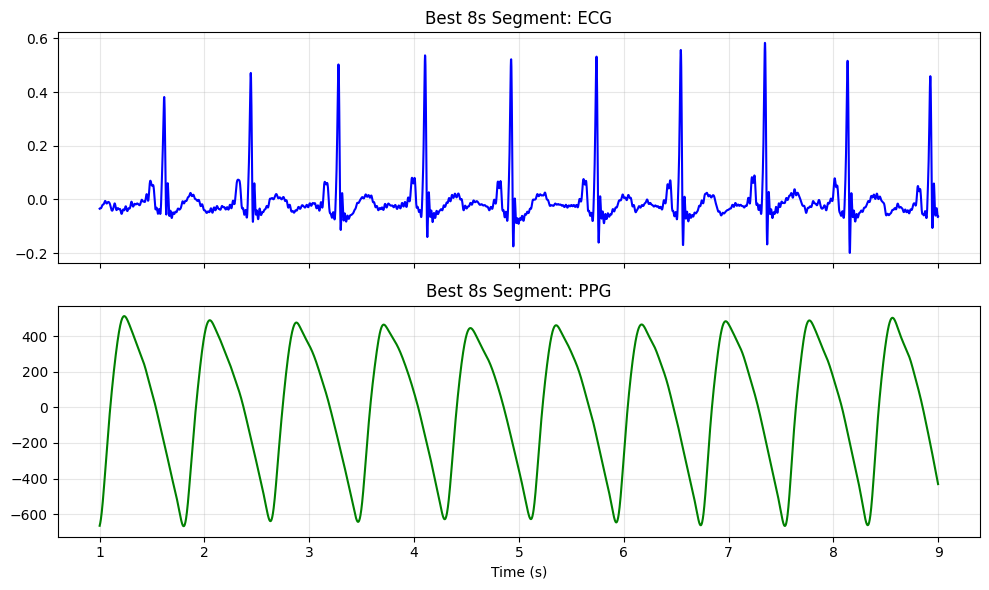

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import kurtosis

# ==========================================
# 1. FILE CONFIGURATION
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join('measurements_oscillometric','measurements_oscillometric','o200','o200.initial.Supine_2.tsv')
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    if not os.path.exists(file_path): return None
    return pd.read_csv(file_path, sep='\t')

# ==========================================
# 2. PROCESSING (Includes Highpass Fix)
# ==========================================
def get_sampling_rate(df):
    if len(df) < 2: return 125.0
    return 1.0 / np.mean(np.diff(df['t']))

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    
    # ECG Processing (With Highpass for Baseline Removal)
    if 'ekg' in df.columns:
        # 1. Highpass (0.5 Hz) - CRITICAL for baseline wander
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        
        # 2. Notch (50-70 Hz)
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        
        # 3. Lowpass (40 Hz)
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, sig_notch)
        
        # 4. Invert Check
        corrected_ecg, _ = nk.ecg_invert(sig_lp, sampling_rate=fs)
        df_filt['ekg'] = corrected_ecg
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. ADVANCED METRICS EXTRACTION
# ==========================================
def analyze_segment_metrics(ecg_chunk, ppg_chunk, fs):
    """
    Returns a dictionary with exact metrics for ranking.
    """
    metrics = {'score': 0, 'reasons': []}
    
    # --- 1. ECG SCORING ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': metrics['score'] += 5
        elif q_class == 'Barely acceptable': metrics['score'] += 2
    except: pass

    # Kurtosis (Higher = Sharper peaks = Better)
    metrics['ecg_kurtosis'] = kurtosis(ecg_chunk)

    # Variance Check (Lower penalty threshold)
    ecg_std = np.std(ecg_chunk)
    if ecg_std > 0.25: 
        metrics['score'] -= 10
        metrics['reasons'].append("HighVar")
    else:
        metrics['score'] += 2

    # --- 2. PPG SCORING ---
    try:
        # Get raw correlation value (0.0 to 1.0)
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        metrics['ppg_match_val'] = q_temp
        
        if q_temp > 0.85: metrics['score'] += 5
        elif q_temp > 0.6: metrics['score'] += 3
    except:
        metrics['ppg_match_val'] = 0.0

    return metrics

# ==========================================
# 4. FIND THE BEST SEGMENT (RANKING LOGIC)
# ==========================================
def find_best_segment(df, fs, duration_sec=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(1.0 * fs) # 1 second step
    
    candidates = []
    
    print("Scanning and ranking segments...")
    
    for i in range(0, len(df) - window_samples, step_samples):
        # Extract Data
        ecg_c = df['ekg'].iloc[i : i+window_samples].values
        ppg_c = df['optical'].iloc[i : i+window_samples].values
        
        # Analyze
        m = analyze_segment_metrics(ecg_c, ppg_c, fs)
        
        # Store Candidate
        candidate = {
            'start_idx': i,
            'end_idx': i+window_samples,
            'time_start': df['t'].iloc[i],
            'total_score': m['score'],
            'ppg_quality': m['ppg_match_val'], # Tie-breaker 1
            'ecg_sharpness': m['ecg_kurtosis'] # Tie-breaker 2
        }
        
        # Only keep decent candidates to save memory
        if m['score'] > 0:
            candidates.append(candidate)
            
    # --- SORTING LOGIC ---
    # 1. Sort by Total Score (Descending)
    # 2. Then by PPG Quality (Descending)
    # 3. Then by ECG Kurtosis (Descending)
    sorted_candidates = sorted(
        candidates, 
        key=lambda x: (x['total_score'], x['ppg_quality'], x['ecg_sharpness']), 
        reverse=True
    )
    
    if not sorted_candidates:
        print("No valid segments found.")
        return None
        
    best = sorted_candidates[0]
    print(f"\nWINNER FOUND!")
    print(f"Time: {best['time_start']:.1f}s")
    print(f"Score: {best['total_score']}")
    print(f"PPG Match: {best['ppg_quality']:.4f} (Perfect=1.0)")
    print(f"ECG Kurtosis: {best['ecg_sharpness']:.2f}")
    
    # Return the dataframe slice of the winner
    return df.iloc[best['start_idx'] : best['end_idx']].copy()

# ==========================================
# MAIN RUN
# ==========================================
df = load_abp_data(FULL_FILE_PATH)
if df is not None:
    # 1. Process
    df_filt, fs = process_all_signals(df)
    
    # 2. Extract Best
    best_segment = find_best_segment(df_filt, fs)
    
    # 3. Plot The Winner
    if best_segment is not None:
        t = best_segment['t']
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        
        ax[0].plot(t, best_segment['ekg'], 'b')
        ax[0].set_title("Best 8s Segment: ECG")
        ax[0].grid(True, alpha=0.3)
        
        ax[1].plot(t, best_segment['optical'], 'g')
        ax[1].set_title("Best 8s Segment: PPG")
        ax[1].set_xlabel("Time (s)")
        ax[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()